## TODO
* Re-write for more than two classes
* Add size binning
* First fix FI, then FM
* Monte Carlo sim to test all permutations; OR:
* Increment steps based on PDF, with each step having an equal prob.

## Description
This script takes as input the landscape inundation fraction, the emergent macrophyte fraction (fraction of all inundated areas), and flux values for these fractions. It then iterates over probable ranges and plots the total flux's sensitivities to these values, Normalized by area.


| Name  | Description | Value |
|---      |---                |---       |
| INPUTS |
FLUXES | Dictionary of flux values by class	| 
FRACTION:IN_TOTAL | Fraction inundated: Range for open water and emergent macrophyte area divided by total landscape area |
FRACTION:EM | Fraction EMERGENT macrophyte: Range for emergent macrophyte area / open water area |
FRACTION:  ... | ...
FRACTION_STEPS | Number of steps for each landcover type (range / increment) |
FLUX_STEPS | Number of steps for flux (range / increment) |


In [17]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [9]:
## inputs

# fluxes={'OW': 100,
#        'GW': 300,
#        'SW': 200}

FRACTION={
    'IN_TOTAL':(10, 38), # Fraction Inundated; From Run 35
    'EM':(2, 60) # Fraction macrophyte: From Run 35
}
FLUXES={
    'OW': (0, 166), # Open water; From range in: Burger et al 2016	Biogeosciences
    'EM': (77, 5800)  # Emergent macrophyte; From range in: Burger et al 2016	Biogeosciences
}
FRACTION_STEPS=40
FLUX_STEPS=40

In [10]:
SENSITIVITY=np.zeros((FRACTION_STEPS, FLUX_STEPS), 'double') # init
FRACTION_POSTINGS=np.linspace(FRACTION['EM'][0], FRACTION['EM'][1], FRACTION_STEPS)
FLUX_POSTINGS=np.linspace(FLUXES['EM'][0], FLUXES['EM'][1], FLUX_STEPS)
for i in range(FRACTION_STEPS):
    for j in range(FLUX_STEPS):
        SENSITIVITY[i,j] = np.mean(FRACTION['IN_TOTAL']) * FRACTION_POSTINGS[i] * FLUX_POSTINGS[j] /100 / 100  # use median?
        

In [11]:
np.mean(FRACTION['IN_TOTAL'])

24.0

In [30]:
?plt.imshow

Signature:
plt.imshow(
    X,
    cmap=None,
    norm=None,
    aspect=None,
    interpolation=None,
    alpha=None,
    vmin=None,
    vmax=None,
    origin=None,
    extent=None,
    shape=<deprecated parameter>,
    filternorm=1,
    filterrad=4.0,
    imlim=<deprecated parameter>,
    resample=None,
    url=None,
    *,
    data=None,
    **kwargs,
)
Docstring:
Display data as an image; i.e. on a 2D regular raster.

The input may either be actual RGB(A) data, or 2D scalar data, which
will be rendered as a pseudocolor image. Note: For actually displaying
a grayscale image set up the color mapping using the parameters
``cmap='gray', vmin=0, vmax=255``.

Parameters
----------
X : array-like or PIL image
    The image data. Supported array shapes are:

    - (M, N): an image with scalar data. The values are mapped to
      colors using normalization and a colormap. See parameters *norm*,
      *cmap*, *vmin*, *vmax*.
    - (M, N, 3): an image with RGB values (0-1 float or 0-255 int).
 

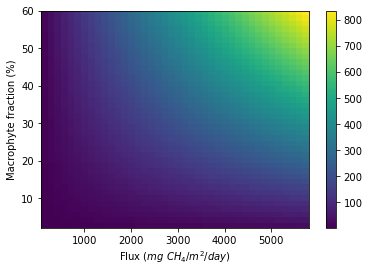

In [41]:
# plt.xticks(FLUX_POSTINGS[0:4:])
# plt.yticks(FRACTION_POSTINGS[0:4:])
p=plt.imshow(SENSITIVITY, origin='lower', aspect='auto', extent=(FLUXES['EM'][0], FLUXES['EM'][1], FRACTION['EM'][0], FRACTION['EM'][1]))
plt.xlabel("Flux ($mg\ CH_4 / m^2 /day$)")
plt.ylabel('Macrophyte fraction (%)')
plt.colorbar()
axes=plt.gca()
# axes.set_xlim(FLUXES['EM'])
# axes.set_ylim(FRACTION['EM'])
# plt.xticks(FLUX_POSTINGS[0:4:])
# plt.yticks(FRACTION_POSTINGS[0:4:])

# KATIA:
#x-axis:
# locs, labels = plt.xticks()
# major_ticks_x_2 = [0,132-72,192-72,252-72,312-72,372-72]
# ticklabels_x_2 = np.arange(1990,2016,5)
# plt.xticks(major_ticks_x_2, ticklabels_x_2)

# minor_ticks_x_2 = np.arange(0,339,12)
# axes.set_xticks(minor_ticks_x_2, minor=True)
# ticklabels_x_2 = np.arange(1990,2016,5)
# axes.set_xticklabels(ticklabels_x_2)

# axes.tick_params(which = 'major', labelsize=9, direction = 'in')
# axes.tick_params(which = 'minor', direction = 'in')

# # y-axis:
# locs, labels = plt.yticks()
# major_ticks_y_2 = np.arange(-0.5,17.5,3)
# ticklabels_y_2 = np.arange(-90,90,30)
# plt.yticks(major_ticks_y_2, ticklabels_y_2)

# minor_ticks_y_2 = np.arange(-0.5,17.5,1)
# axes.set_yticks(minor_ticks_y_2, minor=True)

In [40]:
?plt.ylabel

Signature: plt.ylabel(ylabel, fontdict=None, labelpad=None, **kwargs)
Docstring:
Set the label for the y-axis.

Parameters
----------
ylabel : str
    The label text.

labelpad : scalar, optional, default: None
    Spacing in points from the axes bounding box including ticks
    and tick labels.

Other Parameters
----------------
**kwargs : `.Text` properties
    `.Text` properties control the appearance of the label.

See also
--------
text : for information on how override and the optional args work
File:      ~/miniconda2/envs/ai4ess/lib/python3.8/site-packages/matplotlib/pyplot.py
Type:      function


(77.0, 5800.0)

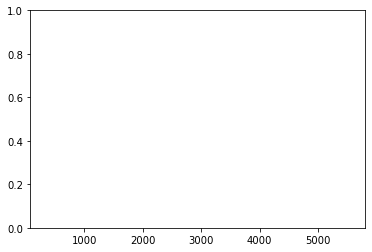

In [94]:
axes=plt.gca()
axes.set_xlim(FLUXES['EM'])

(1, 17)

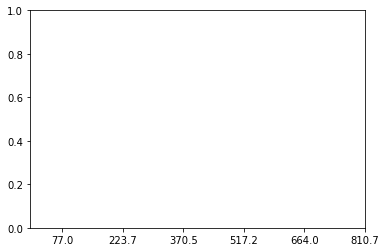

In [102]:
SENSITIVITY
plt.xticks(FLUX_POSTINGS[0:6:])
FLUX_POSTINGS
FLUX_POSTINGS[0:9:]
FRACTION['EM']
# FLUXES['EM']